# Nature Conservancy Fish Classification - Bounding Box Regressor

### Imports & environment

In [1]:
import os
import ujson as json
import PIL

from keras.callbacks import ModelCheckpoint
from keras.layers import GlobalAveragePooling2D, Activation, Input, Flatten
from keras.models import Sequential

from utils import * 
from vgg16bn import Vgg16BN

ROOT_DIR = os.getcwd()
DATA_HOME_DIR = ROOT_DIR + '/data'
%matplotlib inline

Using Theano backend.
Using gpu device 0: GeForce GTX 980M (CNMeM is enabled with initial size: 90.0% of memory, cuDNN 5105)


### Config & Hyperparameters

In [2]:
# paths
data_path = DATA_HOME_DIR + '/' 
split_train_path = data_path + '/train/'
full_train_path = data_path + '/train_full/'
valid_path = data_path + '/valid/'
test_path = DATA_HOME_DIR + '/test/'

# data
batch_size = 8
nb_split_train_samples = 3277
nb_full_train_samples = 3785
nb_valid_samples = 500
nb_test_samples = 1000
classes = ["ALB", "BET", "DOL", "LAG", "NoF", "OTHER", "SHARK", "YFT"]
nb_classes = len(classes)

# model
nb_epoch = 5
n_filters = 128
lr = 1e-2

### Utils

In [3]:
def get_classes(trn_path, val_path, test_path):
    batches = get_batches(trn_path, shuffle=False, batch_size=1, target_size=(270, 480))
    val_batches = get_batches(val_path, shuffle=False, batch_size=1, target_size=(270, 480))
    test_batches = get_batches(test_path, shuffle=False, batch_size=1, target_size=(270, 480))
    return (val_batches.classes, batches.classes, onehot(val_batches.classes), onehot(batches.classes),
        val_batches.filenames, batches.filenames, test_batches.filenames)

In [4]:
(val_classes, trn_classes, val_labels, trn_labels, 
    val_filenames, filenames, test_filenames) = get_classes(split_train_path, valid_path, test_path)

Found 3277 images belonging to 8 classes.
Found 500 images belonging to 8 classes.
Found 1000 images belonging to 1 classes.


In [5]:
raw_filenames = [f.split('/')[-1] for f in filenames]
raw_test_filenames = [f.split('/')[-1] for f in test_filenames]
raw_val_filenames = [f.split('/')[-1] for f in val_filenames]

### Building Model and Saving/Loading Precomputed Conv Features

In [6]:
vgg640 = Vgg16BN((360, 640)).model
vgg640.pop()
vgg640.compile(Adam(), 'categorical_crossentropy', metrics=['accuracy'])

/home/robert/anaconda3/lib/python3.5/site-packages/keras/backend/theano_backend.py:1500: UserWarning: DEPRECATION: the 'ds' parameter is not going to exist anymore as it is going to be replaced by the parameter 'ws'.
  mode='max')
/home/robert/anaconda3/lib/python3.5/site-packages/keras/backend/theano_backend.py:1500: UserWarning: DEPRECATION: the 'st' parameter is not going to exist anymore as it is going to be replaced by the parameter 'stride'.
  mode='max')
/home/robert/anaconda3/lib/python3.5/site-packages/keras/backend/theano_backend.py:1500: UserWarning: DEPRECATION: the 'padding' parameter is not going to exist anymore as it is going to be replaced by the parameter 'pad'.
  mode='max')


In [7]:
# batches = get_batches(split_train_path, batch_size=1, target_size=(360, 640), shuffle=False,
#                       class_mode=None)
# conv_trn_feat = vgg640.predict_generator(batches, nb_split_train_samples)
# save_array(data_path + 'precomputed/trn_ft_640.dat', conv_trn_feat)

# del conv_trn_feat

In [8]:
# val_batches = get_batches(valid_path, batch_size=1, target_size=(360, 640), shuffle=False,
#                           class_mode=None)
# conv_val_feat = vgg640.predict_generator(val_batches, nb_valid_samples)
# save_array(data_path + 'precomputed/val_ft_640.dat', conv_val_feat)

# del conv_val_feat

In [9]:
# test_batches = get_batches(test_path, batch_size=1, target_size=(360, 640), shuffle=False,
#                            class_mode=None)
# conv_test_feat = vgg640.predict_generator(test_batches, nb_test_samples)
# save_array(data_path+'precomputed/test_ft_640.dat', conv_test_feat)

# del conv_test_feat

In [10]:
conv_val_feat = load_array(data_path + 'precomputed/val_ft_640.dat')
conv_trn_feat = load_array(data_path + 'precomputed/trn_ft_640.dat')
conv_test_feat = load_array(data_path + 'precomputed/test_ft_640.dat')

Sample images for visualizing model results (from validation set):

In [11]:
smp = get_data(valid_path, target_size=(360, 640))

Found 500 images belonging to 8 classes.


### Bounding Box Loading and Application

In [12]:
anno_classes = ['alb', 'bet', 'dol', 'lag', 'other', 'shark', 'yft']

In [13]:
bb_json = {}
for c in anno_classes:
    j = json.load(open('bb_annotations/{}.json'.format(c), 'r'))
    for l in j:
        if 'annotations' in l.keys() and len(l['annotations'])>0:
            bb_json[l['filename'].split('/')[-1]] = sorted(
                l['annotations'], key=lambda x: x['height']*x['width'])[-1]
            

bb_json['img_04908.jpg']

{'class': 'rect',
 'height': 246.75000000000074,
 'width': 432.8700000000013,
 'x': 465.3000000000014,
 'y': 496.32000000000147}

In [14]:
file2idx = {o:i for i,o in enumerate(raw_filenames)}
val_file2idx = {o:i for i,o in enumerate(raw_val_filenames)}


For images with no annotations, just use an empty bounding box:


In [15]:
empty_bbox = {'height': 0., 'width': 0., 'x': 0., 'y': 0.}

In [16]:
for f in raw_filenames:
    if not f in bb_json.keys():
        bb_json[f] = empty_bbox
for f in raw_val_filenames:
    if not f in bb_json.keys():
        bb_json[f] = empty_bbox

Convert coordinate to resized 640x360 images:

In [17]:
bb_params = ['height', 'width', 'x', 'y']
def convert_bb(bb, size):
    bb = [bb[p] for p in bb_params]
    conv_x = (640. / size[0])
    conv_y = (360. / size[1])
    bb[0] = bb[0]*conv_y
    bb[1] = bb[1]*conv_x
    bb[2] = max(bb[2]*conv_x, 0)
    bb[3] = max(bb[3]*conv_y, 0)
    return bb

In [18]:
trn_sizes = [PIL.Image.open(full_train_path + f).size for f in filenames]
val_sizes = [PIL.Image.open(valid_path + f).size for f in val_filenames]

In [19]:
trn_bbox = np.stack([convert_bb(bb_json[f], s) for f, s in zip(raw_filenames, trn_sizes)]).astype(np.float32)
val_bbox = np.stack([convert_bb(bb_json[f], s) for f, s in zip(raw_val_filenames, val_sizes)]).astype(np.float32)

Visualize result:

In [20]:
def create_rect(bb, color='red'):
    return plt.Rectangle((bb[2], bb[3]), bb[1], bb[0], color=color, fill=False, lw=3)

def show_bb(i):
    bb = val_bbox[i]
    plot(smp[i])
    plt.gca().add_patch(create_rect(bb))

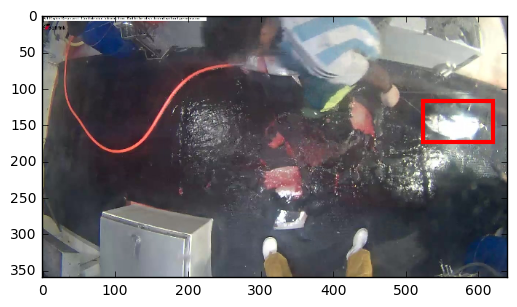

In [21]:
show_bb(0)

### Train the BB Regressor

In [22]:
conv_layers, _ = split_at(vgg640, Convolution2D)
input_shape = conv_layers[-1].output_shape[1:]

del vgg640; del conv_layers

In [23]:
model = Sequential()

model.add(MaxPooling2D(input_shape=input_shape))
model.add(BatchNormalization(axis=1))
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Dense(4))

model.compile(Adam(lr=0.001), loss='mse')

/home/robert/anaconda3/lib/python3.5/site-packages/keras/backend/theano_backend.py:1500: UserWarning: DEPRECATION: the 'ds' parameter is not going to exist anymore as it is going to be replaced by the parameter 'ws'.
  mode='max')
/home/robert/anaconda3/lib/python3.5/site-packages/keras/backend/theano_backend.py:1500: UserWarning: DEPRECATION: the 'st' parameter is not going to exist anymore as it is going to be replaced by the parameter 'stride'.
  mode='max')
/home/robert/anaconda3/lib/python3.5/site-packages/keras/backend/theano_backend.py:1500: UserWarning: DEPRECATION: the 'padding' parameter is not going to exist anymore as it is going to be replaced by the parameter 'pad'.
  mode='max')


In [24]:
model.fit(conv_trn_feat, trn_bbox,
          batch_size=batch_size,
          nb_epoch=3,
          verbose=2,
          validation_data=(conv_val_feat, val_bbox))

Train on 3277 samples, validate on 500 samples
Epoch 1/3
24s - loss: 18248.6090 - val_loss: 7371.9701
Epoch 2/3
21s - loss: 3532.8038 - val_loss: 1708.1818
Epoch 3/3
21s - loss: 1742.2774 - val_loss: 1278.6482


In [26]:
model.optimizer.lr = 1e-7
ckpt = ModelCheckpoint('models/bb_regressor/360x640/loss-{val_loss:.2f}_vgg16_bn.h5', monitor='val_loss',
                       verbose=0, save_best_only=True, save_weights_only=True)

model.fit(conv_trn_feat, trn_bbox,
          batch_size=batch_size,
          nb_epoch=10,
          verbose=2,
          validation_data=(conv_val_feat, val_bbox),
          callbacks=[ckpt])

Train on 3277 samples, validate on 500 samples
Epoch 1/10
22s - loss: 1140.9826 - val_loss: 1176.4752
Epoch 2/10
22s - loss: 1135.9744 - val_loss: 1147.7250
Epoch 3/10
22s - loss: 1144.7114 - val_loss: 1145.7125
Epoch 4/10
22s - loss: 1155.6750 - val_loss: 1103.2005
Epoch 5/10
21s - loss: 1115.7914 - val_loss: 1109.8579
Epoch 6/10
21s - loss: 1110.2211 - val_loss: 1123.4849
Epoch 7/10
21s - loss: 1106.3310 - val_loss: 1142.2711
Epoch 8/10
21s - loss: 1159.8010 - val_loss: 1169.3352
Epoch 9/10
21s - loss: 1148.4655 - val_loss: 1153.5961
Epoch 10/10
21s - loss: 1128.8583 - val_loss: 1121.4265


In [28]:
model.load_weights('models/bb_regressor/360x640/loss-1103.20_vgg16_bn.h5')  # current best

In [29]:
pred = model.predict(conv_val_feat[0:10])

Visualize predictions on sample images:

In [30]:
def show_bb_pred(i):
    bb = val_bbox[i]
    bb_pred = pred[i]
    plt.figure(figsize=(6,6))
    plot(smp[i])
    ax=plt.gca()
    ax.add_patch(create_rect(bb_pred, 'yellow'))
    ax.add_patch(create_rect(bb))

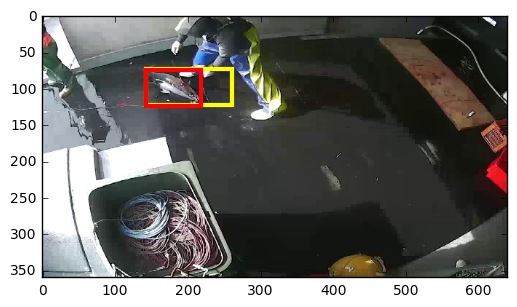

In [37]:
show_bb_pred(7)